In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Farmland & Crops Keras EfficientNet

## Import Package


In [1]:
import os
import time
import datetime
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


## Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:

In [2]:
SEED = 5397
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.set_soft_device_placement(True)

NameError: name 'tf' is not defined

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # Show GPU information
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

Not connected to a TPU runtime. Using CPU/GPU strategy
Found GPU at: /device:GPU:0
Thu Oct 13 22:40:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.59       Driver Version: 512.59       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   55C    P2    27W / 160W |   1053MiB /  6144MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
     

## Const & Inputs

Here are all of the parameters to change for the run.


In [3]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."

# Folder of the training data
training_folder = 'train'

# Folder of the testing data
testing_folder = 'test'

# Number of classes in the dataset
num_classes = 33

# Image size for model
image_size = 224

# Whether to reprocess the data
reprocess = False

# Encoder to choose from [OneHotEncoder, LabelEncoder]
encoder = 'OneHotEncoder'

# enable heatmap
heatmap = False

# Get the shape of the input layer
input_shape = (image_size, image_size, 4 if heatmap else 3)

In [4]:
tw = ["非作物", "甘藍", "甘藷", "檳榔", "芒果", "竹筍", "茶", "蔥", "木瓜", "太陽麻", "紅豆", "毛豆", "芋", "葡萄", "青花菜", "茭白筍", "絲瓜",
      "荔枝", "龍眼", "韭菜", "狼尾草", "檸檬", "萵苣", "花椰菜", "梨", "田菁", "番荔枝", "百香果", "蓮霧", "結球白菜", "溫網室", "洋蔥", "蘆筍"]
en = ["others", "kale", "sweetpotato", "betel", "mango", "bambooshoots", "tea", "greenonion", "papaya", "sunhemp", "redbeans", "soybeans", "taro", "grape", "broccoli", "waterbamboo", "loofah", "litchi",
      "longan", "chinesechives", "pennisetum", "lemon", "lettuce", "cauliflower", "pear", "sesbania", "custardapple", "passionfruit", "roseapple", "chinesecabbage", "greenhouse", "onion", "asparagus"]
classes_name = pd.DataFrame({"tw": tw, "en": en}).sort_values(by=['en'], ignore_index=True)


## Helper Functions

Before we write the code for adjusting the models, lets define a few helper functions.


In [7]:
import cv2
def load_image_and_resize(path, new_size=224, resize_method="resize", padding_method="wrap"):
    """Use CV2 to read image, and resize the image to make the aspect ratio.

    Arguments:
    ----------
        path: string, default=None
            image path. 

        new_size: number, default=500
            desired image size.

        resize_method: 'resize' or 'padding', default='resize'
            resize: only resize.
            padding: padding and resize.

        padding_method: 'wrap' or 'constant'
            wrap: take mirrored pixel padding.
            constant: border padding to a fixed value.

    Returns:
    --------
        image_rgb: 3d-array
            image vector converted to rgb format.
    """
    image = cv2.imread(path)
    height, width, channel = image.shape

    if resize_method == "padding":
        # resize by ratio
        ratio = new_size/max(height, width)
        new_height, new_width = int(ratio * height), int(ratio * width)
        image = cv2.resize(image, (new_width, new_height))

        # calculate boundaries
        top, bottom = (new_size-new_height)//2, (new_size-new_height)//2
        if top + bottom + height < new_size:
            bottom += 1
        left, right = (new_size-new_width)//2, (new_size-new_width)//2
        if left + right + width < new_size:
            right += 1

        # padding
        if padding_method == "wrap":
            image = cv2.copyMakeBorder(
                image, top, bottom, left, right, cv2.BORDER_WRAP)
        elif padding_method == "constant":
            image = cv2.copyMakeBorder(
                image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

    elif resize_method == "resize":
        image = cv2.resize(image, (new_size, new_size),
                           interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [8]:
from scipy.stats import multivariate_normal
def get_gaussian_heatmap(width, height, x, y, cov=None, minmax=True):
    """
    generate heatmap with given width, height and center point.
    """
    pos = np.dstack(np.mgrid[0: height: 1, 0: width: 1])
    rv = multivariate_normal(mean=[(width/2)+x ,(height/2)+y], cov=cov if cov else width * height)
    hm = rv.pdf(pos)
    if minmax:
        return (hm - hm.min()) / (hm.max() - hm.min())
    return hm


## Data Preprocessing

Include: laod data, encode categorical features, split data, normalize data, and save data.


### Load Data
The training set has been randomly split into train(85%) and valid(15%) in advance.

In [5]:
# fullset = pd.read_csv(f'{path}/data/fullset.csv')
# fullset.groupby('set_name').count()
subset = pd.read_pickle(F'{path}/data/subset.pkl')
subset.groupby('set_name').count()

file  label  shape  height  width  make  model  taken_datetime  \
set_name                                                                    
test       2716   2716   2716    2716   2716  1679   1680            1657   
train     12544  12544  12544   12544  12544  7835   7838            7717   
valid      2639   2639   2639    2639   2639  1662   1662            1633   

          taken_month  taken_year  taken_hour  target_fid  target_x  target_y  \
set_name                                                                        
test             1657        1657        1657        2716      2716      2716   
train            7717        7717        7717       12544     12544     12544   
valid            1633        1633        1633        2639      2639      2639   

          county_name  town_name  town_x  town_y  town_z  
set_name                                                  
test             2716       2716    2716    2716    2716  
train           12544      12544   12544   12544   12544  
valid            2639       2639    2639    2639    2639

In [6]:
# train = fullset[fullset['set_name'].eq('train')].reset_index(drop=True)
# valid = fullset[fullset['set_name'].eq('valid')].reset_index(drop=True)
# test = pd.read_csv(F'{path}/data/describe(test).csv')
# test = pd.DataFrame({'filename': [f for f in os.listdir(f'{path}/data/{testing_folder}') if os.path.isfile(os.path.join(f'{path}/data/{testing_folder}', f))]})

In [7]:
train = subset[subset['set_name'].eq('train')].reset_index(drop=True)
valid = subset[subset['set_name'].eq('valid')].reset_index(drop=True)
test = subset[subset['set_name'].eq('test')].reset_index(drop=True)
print(F"train: {train.shape}, valid: {valid.shape}, test: {test.shape}")

train: (12544, 20), valid: (2639, 20), test: (2716, 20)


We can choose to process the data from scratch, or read data that has already been processed.

In [8]:
if(reprocess):
    tqdm.pandas()
    train["vector"] = train.progress_apply(lambda row: load_image_and_resize(F'D:/Dataset/aidea-farmland-crops-autumn/train-correct/{row["label"]}/{row["file"]}', new_size=224, resize_method="resize"), axis=1)
    pd.to_pickle(train, F'{path}/data/subset_train_vector_{image_size}_correct.pkl', protocol=4)
    tqdm.pandas()
    valid["vector"] = valid.progress_apply(lambda row: load_image_and_resize(F'D:/Dataset/aidea-farmland-crops-autumn/train-correct/{row["label"]}/{row["file"]}', new_size=224, resize_method="resize"), axis=1)
    pd.to_pickle(valid, F'{path}/data/subset_valid_vector_{image_size}_correct.pkl', protocol=4)
    tqdm.pandas()
    test["vector"] = test.progress_apply(lambda row: load_image_and_resize(F'D:/Dataset/aidea-farmland-crops-autumn/train-correct/{row["label"]}/{row["file"]}', new_size=224, resize_method="resize"), axis=1)
    pd.to_pickle(test, F'{path}/data/subset_test_vector_{image_size}_correct.pkl', protocol=4)
else:
    train = pd.read_pickle(F'{path}/data/subset_train_vector_224_correct.pkl')
    valid = pd.read_pickle(F'{path}/data/subset_valid_vector_224_correct.pkl')
    test = pd.read_pickle(F'{path}/data/subset_test_vector_224_correct.pkl')

In [27]:
# xx  = np.concatenate((np.array(train['vector'].tolist()), np.array(train['heatmap'].tolist()).reshape(-1, image_size, image_size, 1)), axis=3)
# heatmaps = np.array(train['heatmap'].tolist()).reshape(-1, image_size, image_size, 1)
# heatmaps.shape

In [147]:
# if(heatmap & reprocess):
#     tqdm.pandas()
#     train['heatmap'] = train.progress_apply(lambda row: get_gaussian_heatmap(
#         image_size, image_size, row['target_x'] / row['width'] * image_size, row['target_y'] / row['height'] * image_size) * 255, axis=1).astype('uint8')
#     pd.to_pickle(train, F'{path}/data/subset_train_vector_{image_size}.pkl')
#     tqdm.pandas()
#     valid['heatmap'] = valid.progress_apply(lambda row: get_gaussian_heatmap(
#         image_size, image_size, row['target_x'] / row['width'] * image_size, row['target_y'] / row['height'] * image_size) * 255, axis=1).astype('uint8')
#     pd.to_pickle(valid, F'{path}/data/subset_valid_vector_{image_size}.pkl')
#     tqdm.pandas()
#     test['heatmap'] = test.progress_apply(lambda row: get_gaussian_heatmap(
#         image_size, image_size, row['target_x'] / row['width'] * image_size, row['target_y'] / row['height'] * image_size) * 255, axis=1).astype('uint8')
#     pd.to_pickle(test, F'{path}/data/subset_test_vector_{image_size}.pkl')
# if(heatmap):
#     train['vector'] = train.apply(lambda row: np.concatenate((np.array(row['vector'].tolist()), np.array(row['heatmap'].tolist()).reshape(image_size, image_size, 1)), axis=2), axis=1)
#     valid['vector'] = train.apply(lambda row: np.concatenate((np.array(row['vector'].tolist()), np.array(row['heatmap'].tolist()).reshape(image_size, image_size, 1)), axis=2), axis=1)
#     test['vector'] = train.apply(lambda row: np.concatenate((np.array(row['vector'].tolist()), np.array(row['heatmap'].tolist()).reshape(image_size, image_size, 1)), axis=2), axis=1)

### Encode categorical features

OneHotEncoder or LabelEncoder.


In [9]:
if(encoder == 'OneHotEncoder'):
    from sklearn.preprocessing import OneHotEncoder
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(subset['label'].values.reshape(-1, 1))
    train['class'] = list(np.array(enc.transform(train['label'].values.reshape(-1, 1)).toarray().tolist()))
    valid['class'] = list(np.array(enc.transform(valid['label'].values.reshape(-1, 1)).toarray().tolist()))
    test['class'] = list(np.array(enc.transform(test['label'].values.reshape(-1, 1)).toarray().tolist()))
elif(encoder == 'LabelEncoder'):
    from sklearn.preprocessing import LabelEncoder
    enc = LabelEncoder()
    enc.fit(subset['category'].values)
    train['class'] = np.array(enc.transform(train['label'].values))
    valid['class'] = np.array(enc.transform(valid['label'].values))
    test['class'] = np.array(enc.transform(test['label'].values))

### Deep Image Orientation Angle Detection
https://github.com/pidahbus/deep-image-orientation-angle-detection



In [28]:
def angular_loss_mae(y_true, y_pred):
    """
    Tensorflow custom loss function to be used during training
    :param y_true:
    :param y_pred:
    :return:
    """

    error1 = tf.keras.backend.abs(y_pred - y_true)
    error2 = 360 - error1
    error = tf.keras.backend.minimum(error1, error2)
    mae = tf.keras.backend.mean(error)

    return mae

class OAD:
    def _create_model(self):
        conv_base = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(299, 299, 3))
        for layer in conv_base.layers:
            layer.trainable = False

        img = tf.keras.layers.Input(shape=(299, 299, 3))
        x = conv_base(img)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(512, activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(256, activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(64, activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        y = tf.keras.layers.Dense(1, activation="linear")(x)
        model = tf.keras.models.Model(img, y)
        print(model.summary())
        return model

    def _prepare_generator(self, test_df, dir_path, batch_size):
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)
        df = test_df.copy()
        df["angle"] = df["angle"].astype("float32")
        generator = datagen.flow_from_dataframe(dataframe=df, directory=dir_path, x_col="image", y_col="angle",
                                                class_mode="raw", batch_size=batch_size, target_size=(299, 299))
        return generator

    def load_model(self, checkpoint):
        """

        :param checkpoint: saved model path
        """
        try:
            self.model = tf.keras.models.load_model(checkpoint, custom_objects={"angular_loss_mae":angular_loss_mae})
        except:
            self.model = tf.keras.models.load_model(checkpoint, custom_objects={"angle_rmse": angular_loss_mae})


    def fit(self, train_dir_path, valid_dir_path, train_df_path, valid_df_path,
            batch_size, model_save_dir, initial_checkpoint=None):
        """
        Train Model
        :param train_dir_path: directory path of train images
        :param valid_dir_path: directory path of validation images
        :param train_df_path: csv path of train images
        :param valid_df_path: csv path of validation images
        :param batch_size: train batch size
        :param model_save_dir: directory where model weights will be saved
        :param initial_checkpoint: initial model weights path. If set None model will start training from the beginning.
        """
        if initial_checkpoint:
            print("Loading Model from initial checkpoint")
            self.load_model(initial_checkpoint)
            try:
                epoch = int(initial_checkpoint.split("/")[-1].replace(".h5", ""))
            except:
                epoch=0

        else:
            print("Building Model")
            self.model = self._create_model()
            epoch = 0

        print("Compiling Model")
        self.model.compile(optimizer="adadelta", loss=angular_loss_mae)

        print("Building Generators")
        train_gen = self._prepare_generator(train_df_path, train_dir_path, batch_size)
        valid_gen = self._prepare_generator(valid_df_path, valid_dir_path, batch_size)

        early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=10)
        checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_save_dir, "{epoch}.h5"), save_weights_only=False)
        logs = tf.keras.callbacks.CSVLogger(os.path.join(model_save_dir, "logs.csv"))
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, monitor="val_loss", mode="min", patience=5)

        print("Training Started")
        self.model.fit(train_gen, epochs=3000, validation_data=valid_gen,
                       callbacks=[early_stop, checkpoint, logs, reduce_lr], initial_epoch=epoch)

    def predict(self, test_dir_path, test_df, batch_size):
        """
        Predicts angle output
        :param test_dir_path: directory path of test images
        :param test_df_path: csv path of test images
        :param batch_size: prediction batch size
        :return: prediction angle as array
        """
        print("Prediction Started")
        test_gen = self._prepare_generator(test_df, test_dir_path, batch_size)
        preds = self.model.predict(test_gen, batch_size=batch_size)
        return preds


In [ ]:
train['image'] = train['label'] + '/' + train['file']
train['angle'] = 0.0
train.head(3)

In [30]:
# Load Saved Model
model = OAD()
model.load_model("./models/image_orientation_angle_detection.h5")

In [32]:
# Get Predictions
simples_idx = np.random.randint(0, len(train), 24)
simples = train.iloc[simples_idx].reset_index(drop=True)
pred_angles = model.predict("D:/Dataset/aidea-farmland-crops-autumn/train", simples, 32)

Prediction Started
Found 24 validated image filenames.


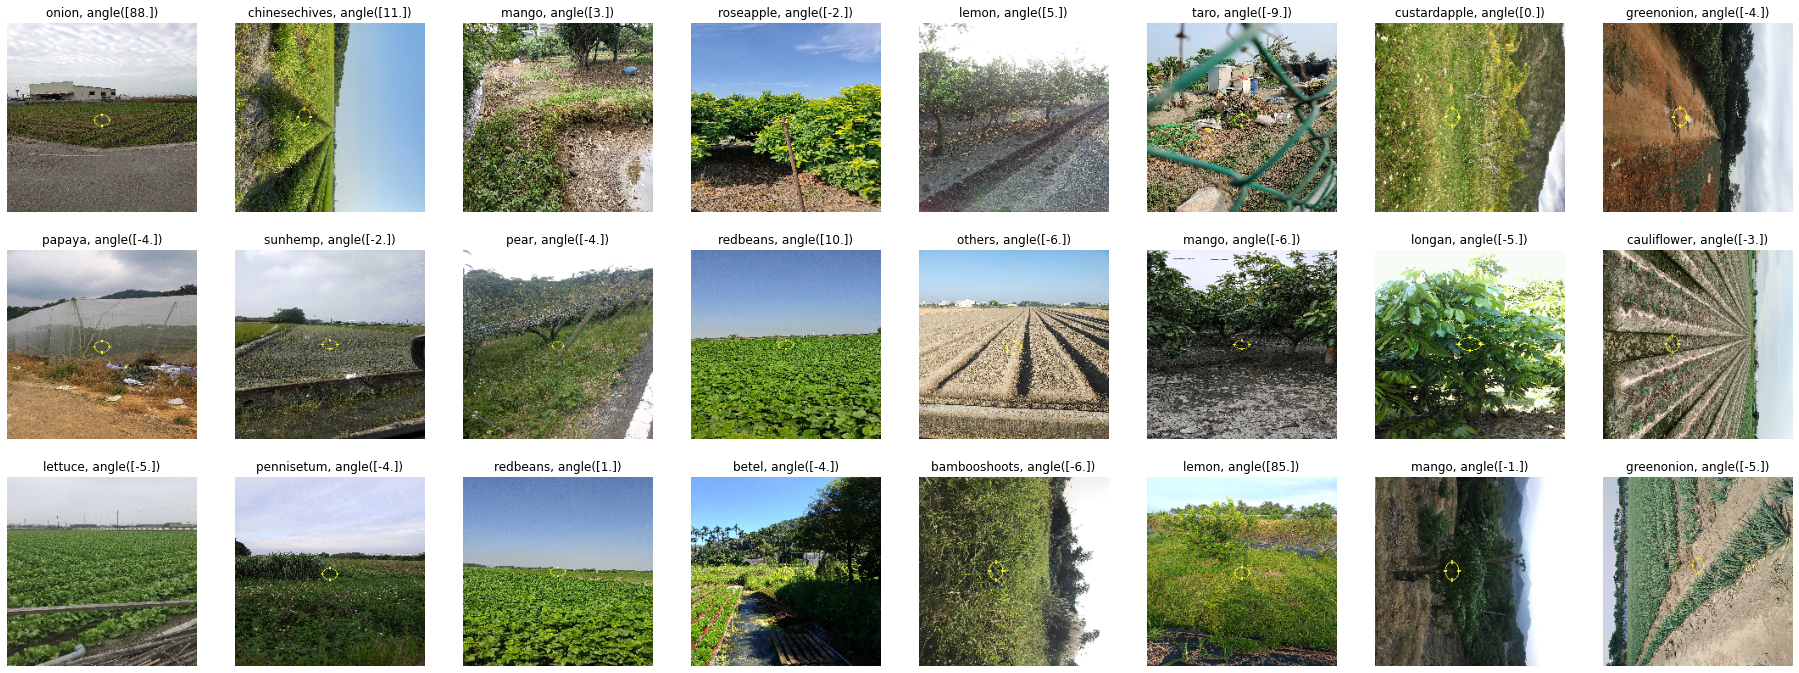

In [52]:
# show rotated image, rotated by predicted angle
plt.figure(figsize=(32, 16))
for item in range(len(simples)):
    image, label = simples.iloc[item]['vector'], simples.iloc[item]['label']
    ax = plt.subplot(len(simples)//8 + 1, 8, item + 1)
    # original
    plt.imshow(image.astype("uint8"))
    plt.title("{}, angle({})".format(label, np.round(pred_angles[item])))
    plt.axis("off")

## Model Helper

In [ ]:
def get_reducelr():
    return tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=np.sqrt(0.1),
        patience=10,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=0.5e-7,
    )

In [ ]:
def get_tensorboard(path):
    return tf.keras.callbacks.TensorBoard(log_dir=path)

In [ ]:
def get_checkpoint(model_name, monitor):
    return tf.keras.callbacks.ModelCheckpoint(
        model_name,
        monitor=monitor,
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        save_freq='epoch'
    )

In [ ]:
def get_early_stop(patience):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=0,
        patience=patience,
        restore_best_weights=True
    )

## EfficientNet modelling + training

Using EfficientNetB0~B7.


### Initialize and Reshape the Networks


In [10]:
def get_augmentation():
    augmentation = tf.keras.models.Sequential()
    # augmentation.add(tf.keras.layers.RandomContrast(factor=0.15))
    augmentation.add(tf.keras.layers.RandomFlip('horizontal_and_vertical'))
    # augmentation.add(tf.keras.layers.RandomZoom(0.15, 0.15))
    augmentation.add(tf.keras.layers.RandomTranslation(height_factor=0.15, width_factor=0.15))
    augmentation.add(tf.keras.layers.RandomRotation(factor=0.15))
    return augmentation

In [11]:
def get_model(input_shape, num_classes, learning_rate=5e-04, dropout=0.2, isAugmentationActivated=False):
    model = tf.keras.models.Sequential()
    if(isAugmentationActivated):
      model.add(get_augmentation())
    model.add(tf.keras.applications.EfficientNetB3(input_shape=input_shape, include_top=False, weights='imagenet', drop_connect_rate=dropout))
    model.add(tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"))
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_initializer=tf.keras.initializers.he_uniform(seed=5397), name="pred"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'], run_eagerly=False)
    return model  
def get_complicated_model(input_shape, num_classes, learning_rate=5e-04, dropout=0.2, isAugmentationActivated=False):
    model = tf.keras.models.Sequential()
    if(isAugmentationActivated):
      model.add(get_augmentation())
    model.add(tf.keras.applications.EfficientNetB3(input_shape=input_shape, include_top=False, weights='imagenet'))
    model.add(tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(units=256, activation='softmax', kernel_initializer=tf.keras.initializers.he_uniform(seed=5397), name="pred"))
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_initializer=tf.keras.initializers.he_uniform(seed=5397), name="pred"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'], run_eagerly=False)
    return model  

In [12]:
def get_batch_dataset(train_vector, train_class, valid_vector, valid_class, batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices((train_vector, train_class)).shuffle(5000, seed=5397).batch(batch_size, drop_remainder=True)
    valid_ds = tf.data.Dataset.from_tensor_slices((valid_vector, valid_class)).batch(batch_size, drop_remainder=True)
    return train_ds, valid_ds
def data_generator(dataframe):
    for i, row in dataframe.iterrows():   
        yield (np.array(row['vector'].tolist())), np.array(row['class'].tolist())
def get_batch_dataset_from_generator(train, valid, input_shape, num_classes, batch_size):
    train_ds = tf.data.Dataset.from_generator(lambda: data_generator(train.sample(frac=1).reset_index(drop=True)), 
        output_types=(tf.uint8, tf.float64), 
        output_shapes=([input_shape[0], input_shape[1], input_shape[2]], [num_classes])).batch(batch_size, drop_remainder=True)
    valid_ds = tf.data.Dataset.from_generator(lambda: data_generator(valid),
        output_types=(tf.uint8, tf.float64), 
        output_shapes=([input_shape[0], input_shape[1], input_shape[2]], [num_classes])).batch(batch_size, drop_remainder=True)
    return train_ds, valid_ds

### Visualize data augmentation 
圖片不太有歪斜的情況，大多是 90 度翻轉 (可能是相機拿反)

In [ ]:
def get_augmentation():
    augmentation = tf.keras.models.Sequential()
    # augmentation.add(tf.keras.layers.RandomContrast(factor=0.15))
    # augmentation.add(tf.keras.layers.RandomFlip('horizontal_and_vertical'))
    # augmentation.add(tf.keras.layers.RandomZoom(0.15, 0.15))
    augmentation.add(tf.keras.layers.RandomTranslation(height_factor=0.15, width_factor=0.15))
    # augmentation.add(tf.keras.layers.RandomRotation(factor=0.15))
    return augmentation

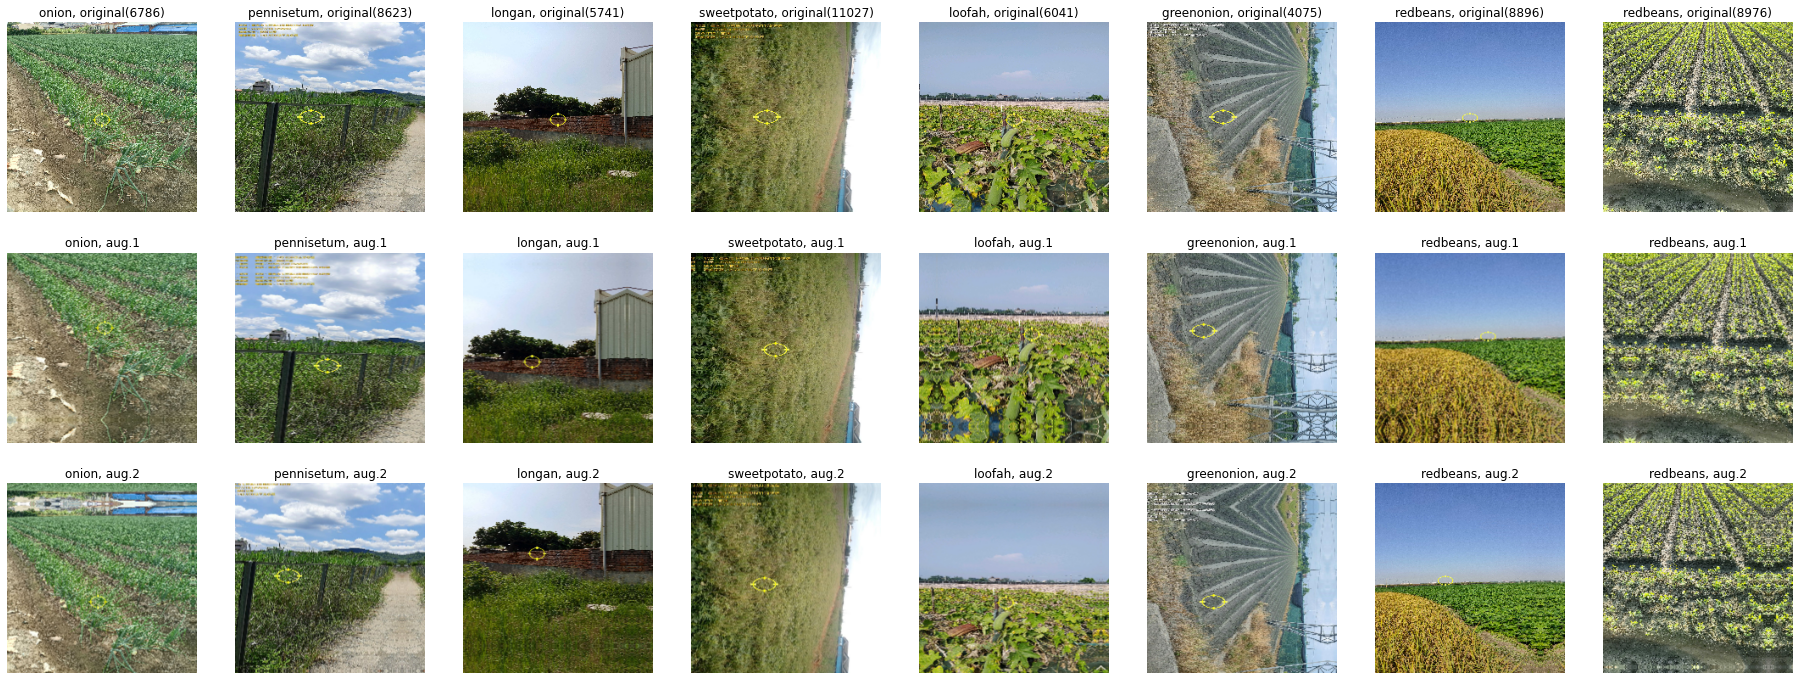

In [64]:
def row_based_idx(num_rows, num_cols, idx):
    return np.arange(1, num_rows*num_cols + 1).reshape((num_rows, num_cols)).transpose().flatten()[idx-1]

items = 8
variants = 2
augmentation = get_augmentation()
plt.figure(figsize=(items * 4, variants * 6))
for item in range(items):
    idx = random.randint(0, len(train_vector))
    image, label = train_vector[idx], train_class[idx]
    ax = plt.subplot((variants + 1), items, row_based_idx((variants + 1), items, item * (variants + 1) + 1))
    # original
    plt.imshow(image.astype("uint8"))
    plt.title("{}, original({})".format(classes_name['en'][np.argmax(label)], idx))
    plt.axis("off")
    # aug_img_1
    ax = plt.subplot((variants + 1), items, row_based_idx((variants + 1), items, item * (variants + 1) + 2))
    aug_img_1 = augmentation(image)
    plt.imshow(aug_img_1.numpy().astype("uint8"))
    plt.title("{}, aug.{}".format(classes_name['en'][np.argmax(label)], 1))
    plt.axis("off")
    # aug_img_2
    ax = plt.subplot((variants + 1), items, row_based_idx((variants + 1), items, item * (variants + 1) + 3))
    aug_img_2 = augmentation(image)
    plt.imshow(aug_img_2.numpy().astype("uint8"))
    plt.title("{}, aug.{}".format(classes_name['en'][np.argmax(label)], 2))
    plt.axis("off")

### Modelling


In [13]:
# [10, 30, 50, 100, 150]
EPOCHS = 100

# [16, 32(default), 64, 128, 256, 512, 1024]
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

# learning rate
LR_START = 5e-04

DROPOUT = 0.4

# Define model name
model_name = F'subset_{input_shape[0]}_efficientnetb3_transfer_trainable_heatmap_epochs{EPOCHS}_batchsize{BATCH_SIZE}_lr{LR_START}_reducelr_dropout{int(DROPOUT*100)}'

In [17]:
# Check model is exist
if os.path.exists(F'{path}/models/{model_name}.h5'):
    # stop training if model is exist
    raise SystemExit(F'{model_name} is exist')

In [ ]:
# Dataset to train
train_vector, train_class = np.array(train['vector'].tolist()), np.array(train['class'].tolist()) 
valid_vector, valid_class = np.array(valid['vector'].tolist()), np.array(valid['class'].tolist()) 
train_ds, valid_ds = get_batch_dataset(train_vector, train_class, valid_vector, valid_class, BATCH_SIZE)

In [ ]:
with strategy.scope():    
    model = get_model(input_shape, num_classes, LR_START, DROPOUT, isAugmentationActivated=True)

In [ ]:
start = time.time()

# Train model
history = model.fit(
  train_ds,
  epochs=EPOCHS,
  validation_data=valid_ds,
  verbose=2,
  # sample_weight=sample_weight,
  callbacks=[
    get_checkpoint(F'{path}/models/{model_name}.h5', 'val_categorical_accuracy'), 
    # get_tensorboard(F'{path}/tensorboard/{model_name}'),
    get_early_stop(50),
    get_reducelr(),
  ],
)

# Save history
history = pd.DataFrame(history.history)
history.to_csv(F'{path}/logs/{model_name}.csv', index=False)

end = time.time()
print(format(end-start))
# get_batch_dataset_from_generator(test, valid), B0, GPU: 900s
# get_batch_dataset(test, valid), B5, GPU: 600s
# get_batch_dataset(test, valid), B0, TPU: 96s (第 2 次 6s)
# get_batch_dataset(train, valid), B3, TPU: 122s (第 2 次 16s)


epochs:  62


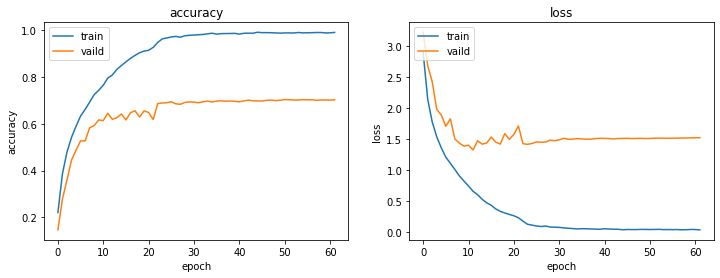

In [ ]:
b6log = pd.read_csv(F'{path}/logs/{model_name}.csv')
print('epochs: ',len(b6log))
plt.figure(figsize=(12, 4))

# Summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(b6log['categorical_accuracy'])
plt.plot(b6log['val_categorical_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'vaild'], loc='upper left') 

# Summarize history for loss 
plt.subplot(1, 2, 2)
plt.plot(b6log['loss']) 
plt.plot(b6log['val_loss']) 
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vaild'], loc='upper left') 
# plt.show()
# save image
plt.savefig(F'{path}/logs/{model_name}.jpg')

### Prediction of vaild
Prediction based on the best model during training

In [14]:
def apply_county_rules(label, county_name):
    if(county_name == '臺北市'):
        label =  "others"
        print('臺北市')
    elif(county_name == '新北市'):
        label = "waterbamboo"
        print('新北市')
    elif(county_name == '宜蘭縣'):
        label = "pear"
        print('宜蘭縣')
    elif(county_name == '臺東縣'):
        label = "custardapple"
        print('臺東縣')
    return label

In [19]:
!pip install -U scikit-learn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def evaluate(y_true, y_pred,zero_division = 1):
    labels = sorted(list(set(y_true + y_pred)))
    eval_result = classification_report(
        y_true, y_pred, target_names=labels, 
        output_dict=True, zero_division=zero_division
    )
    return eval_result

In [27]:
def inverse_and_evaluate(pred_probability, true_probability, df, encoder):
    # Transform the encoded predictions to their actual values
    pred_class_inverse = encoder.inverse_transform(pred_probability).reshape(-1)
    # apply county rules by index
    # pred_class_inverse = df.apply(lambda row: apply_county_rules(pred_class_inverse[row.name], row['county_name']), axis=1)
    true_class_inverse = encoder.inverse_transform(true_probability).reshape(-1)
    # Evaluate the model
    evaluation = evaluate(true_class_inverse.tolist(), pred_class_inverse.tolist())
    return evaluation

In [19]:
# Dataset to valid
test_vector, test_class = np.array(test['vector'].tolist()), np.array(test['class'].tolist())

In [21]:
model_name = "subset_224_correct_ensemble_efficientnetb3_transfer_trainable_epochs100_batchsize256_lr0.0005_reducelr_dropout40"

In [ ]:
# Load model with the best validation accuracy
with strategy.scope():    
    model = get_model(input_shape, num_classes)
    model.load_weights(F'{path}/models/{model_name}.h5')

In [38]:
# Predict the response for train dataset
train['pred_prob'] = list(model.predict(train_vector, verbose=1))
train['pred_label'] = enc.inverse_transform(train['pred_prob'].tolist()).reshape(-1)
# Predict the response for valid dataset
valid['pred_prob'] = list(model.predict(valid_vector, verbose=1))
valid['pred_label'] = enc.inverse_transform(valid['pred_prob'].tolist()).reshape(-1)
# Predict the response for test dataset
test['pred_prob'] = list(model.predict(test_vector, verbose=1))
test['pred_label'] = enc.inverse_transform(test['pred_prob'].tolist()).reshape(-1)
# Save result
result = pd.concat([train, valid, test], ignore_index=True)
result = result[['file', 'label', 'height', 'width', 'target_fid', 'target_x', 'target_y', 'county_name', 'town_name', 'town_x', 'town_y', 'town_z', 'set_name', 'pred_prob', 'pred_label']]
result.to_pickle(F'{path}/results/{model_name}.pkl', protocol=4)

85/85 [==============================] - 8s 98ms/step


In [56]:
a = pd.read_pickle(F'{path}/results/subset_224_efficientnetb3_transfer_trainable_epochs100_batchsize256_lr0.0005_reducelr_dropout40.pkl')
b = pd.read_pickle(F'{path}/results/subset_224_efficientnetb3_transfer_trainable_datagen3_epochs100_batchsize256_lr0.0005_reducelr_dropout40.pkl')
c = pd.read_pickle(F'{path}/results/subset_224_correct_efficientnetb3_transfer_trainable_epochs100_batchsize256_lr0.0005_reducelr_dropout40.pkl')

In [57]:
result = a.copy()
result['pred_prob'] = list((np.array(a['pred_prob'].tolist()) + np.array(b['pred_prob'].tolist())) / 2)
result['pred_label'] = enc.inverse_transform(np.array(result['pred_prob'].tolist())).reshape(-1)

In [66]:
# Evaluate: rebuild dataframe
rtrain = result[result['set_name'].eq('train')].reset_index(drop=True)
rvalid = result[result['set_name'].eq('valid')].reset_index(drop=True)
rtest = result[result['set_name'].eq('test')].reset_index(drop=True)
# Evaluate: calculate accuracy
train_evaluation = evaluate(rtrain['label'].tolist(), rtrain['pred_label'].tolist())['weighted avg']
train_evaluation = {F'train.{key}': value for key, value in train_evaluation.items()}
valid_evaluation = evaluate(rvalid['label'].tolist(), rvalid['pred_label'].tolist())['weighted avg']
valid_evaluation = {F'valid.{key}': value for key, value in valid_evaluation.items()}
test_evaluation = evaluate(rtest['label'].tolist(), rtest['pred_label'].tolist())['weighted avg']
test_evaluation = {F'test.{key}': value for key, value in test_evaluation.items()}
evaluation = pd.DataFrame([{'experiment': model_name, 'datetime': datetime.datetime.now(), **train_evaluation, **valid_evaluation, **test_evaluation}])
# evaluation = pd.DataFrame([{'experiment': model_name, 'datetime': datetime.datetime.now(), 'spend(s)': round(end-start), 'epochs': len(history), **train_evaluation, **valid_evaluation, **test_evaluation}])

In [67]:
# 集成有改善績效
evaluation

experiment  \
0  subset_224_correct_ensemble_efficientnetb3_tra...   

                    datetime  train.precision  train.recall  train.f1-score  \
0 2022-10-14 00:25:04.455594              1.0           1.0             1.0   

   train.support  valid.precision  valid.recall  valid.f1-score  \
0          12544         0.746855      0.744979        0.743156   

   valid.support  test.precision  test.recall  test.f1-score  test.support  
0           2639        0.711562      0.70729       0.707237          2716

In [68]:
pd.DataFrame(evaluate(rtest['label'].tolist(), rtest['pred_label'].tolist())).T

precision    recall  f1-score     support
asparagus        0.852459  0.838710  0.845528    62.00000
bambooshoots     0.550847  0.677083  0.607477    96.00000
betel            0.620370  0.705263  0.660099    95.00000
broccoli         0.710280  0.767677  0.737864    99.00000
cauliflower      0.578125  0.506849  0.540146    73.00000
chinesecabbage   0.647059  0.676923  0.661654    65.00000
chinesechives    0.925373  0.861111  0.892086    72.00000
custardapple     0.814286  0.770270  0.791667    74.00000
grape            0.757009  0.852632  0.801980    95.00000
greenhouse       0.686567  0.707692  0.696970    65.00000
greenonion       0.696629  0.645833  0.670270    96.00000
kale             0.747253  0.701031  0.723404    97.00000
lemon            0.684211  0.722222  0.702703    72.00000
lettuce          0.681159  0.635135  0.657343    74.00000
litchi           0.661290  0.585714  0.621212    70.00000
longan           0.448276  0.527027  0.484472    74.00000
loofah           0.574074  0.430556  0.492063    72.00000
mango            0.423423  0.484536  0.451923    97.00000
onion            0.768116  0.828125  0.796992    64.00000
others           0.426471  0.446154  0.436090    65.00000
papaya           0.618421  0.489583  0.546512    96.00000
passionfruit     0.866667  0.702703  0.776119    74.00000
pear             0.873239  0.849315  0.861111    73.00000
pennisetum       0.836066  0.698630  0.761194    73.00000
redbeans         0.800000  0.916667  0.854369    96.00000
roseapple        0.793103  0.666667  0.724409    69.00000
sesbania         0.680556  0.662162  0.671233    74.00000
soybeans         0.829787  0.821053  0.825397    95.00000
sunhemp          0.786408  0.826531  0.805970    98.00000
sweetpotato      0.551020  0.562500  0.556701    96.00000
taro             0.721154  0.750000  0.735294   100.00000
tea              0.927835  0.937500  0.932642    96.00000
waterbamboo      0.929293  0.929293  0.929293    99.00000
accuracy         0.707290  0.707290  0.707290     0.70729
macro avg        0.711116  0.702520  0.704612  2716.00000
weighted avg     0.711562  0.707290  0.707237  2716.00000

In [37]:
pd.DataFrame(evaluate(a[a['set_name'].eq('test')]['label'].tolist(), a[a['set_name'].eq('test')]['pred_label'].tolist())).T

precision    recall  f1-score      support
asparagus        0.844828  0.790323  0.816667    62.000000
bambooshoots     0.541284  0.614583  0.575610    96.000000
betel            0.577320  0.589474  0.583333    95.000000
broccoli         0.672897  0.727273  0.699029    99.000000
cauliflower      0.440000  0.452055  0.445946    73.000000
chinesecabbage   0.676471  0.707692  0.691729    65.000000
chinesechives    0.845070  0.833333  0.839161    72.000000
custardapple     0.675325  0.702703  0.688742    74.000000
grape            0.766990  0.831579  0.797980    95.000000
greenhouse       0.693548  0.661538  0.677165    65.000000
greenonion       0.647727  0.593750  0.619565    96.000000
kale             0.761905  0.659794  0.707182    97.000000
lemon            0.626667  0.652778  0.639456    72.000000
lettuce          0.682540  0.581081  0.627737    74.000000
litchi           0.551282  0.614286  0.581081    70.000000
longan           0.512821  0.540541  0.526316    74.000000
loofah           0.492063  0.430556  0.459259    72.000000
mango            0.398058  0.422680  0.410000    97.000000
onion            0.761194  0.796875  0.778626    64.000000
others           0.382353  0.400000  0.390977    65.000000
papaya           0.560440  0.531250  0.545455    96.000000
passionfruit     0.754098  0.621622  0.681481    74.000000
pear             0.865672  0.794521  0.828571    73.000000
pennisetum       0.757576  0.684932  0.719424    73.000000
redbeans         0.725664  0.854167  0.784689    96.000000
roseapple        0.666667  0.637681  0.651852    69.000000
sesbania         0.632184  0.743243  0.683230    74.000000
soybeans         0.800000  0.757895  0.778378    95.000000
sunhemp          0.732143  0.836735  0.780952    98.000000
sweetpotato      0.583333  0.510417  0.544444    96.000000
taro             0.744444  0.670000  0.705263   100.000000
tea              0.887755  0.906250  0.896907    96.000000
waterbamboo      0.907216  0.888889  0.897959    99.000000
accuracy         0.671208  0.671208  0.671208     0.671208
macro avg        0.671743  0.667894  0.668308  2716.000000
weighted avg     0.673897  0.671208  0.671005  2716.000000

In [ ]:
evaluations = pd.read_csv(F'{path}/evaluations.csv')
evaluations = evaluations.append(evaluation).reset_index(drop=True)
evaluations.to_csv(F'{path}/evaluations.csv', index=False)
evaluations

experiment  \
0   subset_224_efficientnetb3_transfer_trainable_e...   
1   subset_224_efficientnetb3_transfer_trainable_e...   
2   subset_224_efficientnetb3_transfer_trainable_e...   
3   subset_224_efficientnetb3_transfer_trainable_e...   
4   subset_224_efficientnetb3_transfer_trainable_e...   
5   subset_224_efficientnetb3_transfer_trainable_d...   
6   subset_224_efficientnetb3_transfer_trainable_d...   
7   subset_224_efficientnetb3_transfer_trainable_d...   
8   subset_224_efficientnetb3_transfer_trainable_e...   
9   subset_224_efficientnetb3_transfer_trainable_e...   
10  subset_224_efficientnetb3_transfer_trainable_d...   
11  subset_224_efficientnetb3_transfer_trainable_d...   

                      datetime  spend(s)  epochs  train.precision  \
0   2022-09-26 15:22:24.046359       934      54         1.000000   
1   2022-09-26 15:42:41.428811       805      54         1.000000   
2   2022-09-27 00:41:45.633519       814      55         1.000000   
3   2022-09-27 01:30:06.398147       972      70         1.000000   
4   2022-09-27 01:54:58.254381       871      59         1.000000   
5   2022-09-27 03:00:37.810554      3387      77         0.874155   
6   2022-09-27 05:01:37.637097      3385      77         0.895014   
7   2022-09-27 05:55:00.841539      2789      63         0.985138   
8   2022-09-27 07:08:27.128686       868      57         1.000000   
9   2022-09-27 07:28:39.813399       837      57         0.999444   
10  2022-09-27 08:20:43.198481      2720      63         0.998730   
11  2022-09-27 09:40:18.439530      2747      62         0.996755   

    train.recall  train.f1-score  train.support  train.accuracy  \
0       1.000000        1.000000          12544             1.0   
1       1.000000        1.000000          12544             NaN   
2       1.000000        1.000000          12544             NaN   
3       1.000000        1.000000          12544             NaN   
4       1.000000        1.000000          12544             NaN   
5       0.863839        0.864494          12544             NaN   
6       0.891422        0.890792          12544             NaN   
7       0.984933        0.984946          12544             NaN   
8       1.000000        1.000000          12544             NaN   
9       0.999442        0.999442          12544             NaN   
10      0.998724        0.998724          12544             NaN   
11      0.996732        0.996728          12544             NaN   

    train.final score  ...  valid.f1-score  valid.support  valid.accuracy  \
0                 1.0  ...        0.701696           2639        0.703676   
1                 NaN  ...        0.689410           2639             NaN   
2                 NaN  ...        0.682404           2639             NaN   
3                 NaN  ...        0.619822           2639             NaN   
4                 NaN  ...        0.650554           2639             NaN   
5                 NaN  ...        0.595981           2639             NaN   
6                 NaN  ...        0.603381           2639             NaN   
7                 NaN  ...        0.663791           2639             NaN   
8                 NaN  ...        0.716984           2639             NaN   
9                 NaN  ...        0.672063           2639             NaN   
10                NaN  ...        0.711925           2639             NaN   
11                NaN  ...        0.709354           2639             NaN   

    valid.final score  test.precision  test.recall  test.f1-score  \
0            0.702686        0.678877     0.678940       0.677036   
1                 NaN        0.663671     0.663844       0.661682   
2                 NaN        0.657781     0.658321       0.656270   
3                 NaN        0.608333     0.603461       0.604422   
4                 NaN        0.624957     0.624448       0.622261   
5                 NaN        0.583692     0.569219       0.567676   
6                 NaN        0.605022     0.59